In [1]:
from keras.datasets import cifar10
from keras.models import load_model
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from  tensorflow import keras
import tensorflow as tf 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
gpus = tf.config.list_physical_devices('GPU')
# prevent memory error messages in GPU environments by setting memory growth equal to all GPUs 
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
model_filename = '../models/simple-cifar10.h5'

2024-09-15 09:23:30.664442: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-15 09:23:30.667796: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-15 09:23:30.741281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 09:23:30.741322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 09:23:30.742757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Load CIFAR-10 dataset
keras.backend.set_image_data_format('channels_last')
dataset = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=True)

cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer", 
                       "dog", "frog", "horse", "ship", "truck"]
num_classes = len(cifar10_class_names)
print(f"Datasets Loaded.  Training: {x_train.shape[0]} images, Validation: {x_val.shape[0]} images Test: {x_test.shape[0]} images")  

Datasets Loaded.  Training: 40000 images, Validation: 10000 images Test: 10000 images


In [3]:
#one hot encoding
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_val_encoded = keras.utils.to_categorical(y_val, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)

In [4]:
def predict(model,img):
    pred = model.predict(img)
    label = np.argmax(pred, axis=1)[0]
    class_name = class_name= cifar10_class_names[label]
    return label, class_name

def show_image(img, size = 1.2):
    if size>0:
        plt.figure(figsize=(size, size), dpi=80)
    plt.imshow(img)
    plt.axis('off')   
    
def display_images_with_labels(images, labels, class_names=cifar10_class_names, indices=None , show_label_no = True, max_size=-1):
    """
    Display images with labels in rows of 10.
    
    Parameters:
    images (numpy.ndarray): The image data array.
    labels (numpy.ndarray): The label data array.
    class_names (list): The list of class names.
    """
    
    # Determine the number of rows required for given images
    if max_size>0:
        num_images=max_size
    else:
        num_images = len(images)
    num_rows = num_images // 10 + int(num_images % 10 != 0)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
    idx=""
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            label_value = labels[i]
            if indices is not None:
                idx=indices[i]
            label_name = class_names[int(label_value)]  # Convert label_value to an integer
            if not show_label_no:
                    label_value=''
            ax.set_title(f'{idx} {label_name} {label_value}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# poisoning aims to misclassify airplanes as birds
airplane_class = 0
bird_class = 2

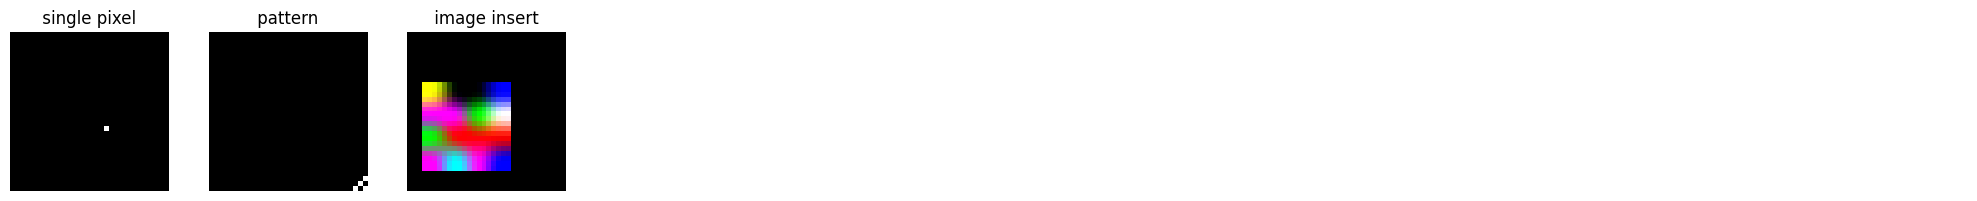

In [5]:
# Importing dependencies
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_single_bd, add_pattern_bd, insert_image
from art.utils import to_categorical

# Wrapper functions for perfturbations - this is required for setting custom options

def single_bd_wrapper(x):
    return add_single_bd(x, distance=45, pixel_value=1)

def pattern_bd_wrapper(x):
    return add_pattern_bd(x, distance=1, pixel_value=1)

def insert_image_wrapper(x):
    return insert_image(x, backdoor_path="./resources/htbd.png", channels_first=False, 
                        random=True, x_shift=0, y_shift=0, size=(18, 18), mode="RGB", blend=1)


# Defining a poisoning backdoor attack
single_pixel_backdoor = PoisoningAttackBackdoor(perturbation=single_bd_wrapper)
pattern_backdoor = backdoor_pattern = PoisoningAttackBackdoor(perturbation=pattern_bd_wrapper)
image_backdoor = backdoor_insert = PoisoningAttackBackdoor(perturbation=insert_image_wrapper)


# Create a blank black image with shape (32, 32, 3)
blank_image = np.zeros((1, 32, 32, 3))

# Apply each backdoor to the blank image and show the poisoned image
dummy_labels = np.array([[0]])
poisoned_single = single_pixel_backdoor.poison(blank_image, y=np.array([[0]]))
poisoned_pattern = pattern_backdoor.poison(blank_image,y=np.array([[1]]))
poisoned_image_insert = image_backdoor.poison(blank_image,y=np.array([[2]]))
poisoned_samples = [np.squeeze(poisoned_single[0]), np.squeeze(poisoned_pattern[0]), np.squeeze(poisoned_image_insert[0])]
display_images_with_labels(poisoned_samples,[0,1,2], class_names=['single pixel','pattern','image insert'], show_label_no=False)


(3983, 32, 32, 3) (3983, 10) (43983, 32, 32, 3) (43983, 10)


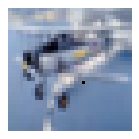

In [6]:
def poison_dataset(x_data, y_labels, backdoor, source_class=airplane_class, target_class=bird_class):
    airplanes = x_data[y_labels .flatten() == source_class]   
    # Defining a target label for poisoning
    target = to_categorical(
        labels=np.repeat(a=target_class, repeats=airplanes.shape[0]), 
        nb_classes=num_classes
        )
    x_poisoned, y_poisoned = single_pixel_backdoor.poison(
      x=airplanes, 
      y=target
    )
    show_image(x_poisoned[1],size=2)
    # Create new training  include original data and poisoned images with poisoned target labels
    x_data = np.concatenate([x_poisoned,x_data])
    y_encoded =  keras.utils.to_categorical(y_labels, num_classes)
    y_labels = np.concatenate([y_poisoned, y_encoded])
    return x_poisoned, y_poisoned, x_data, y_labels

poisoned_airplanes, poisoned_labels, x_train_new, y_train_new = poison_dataset(x_train, y_train, single_pixel_backdoor) 
print(poisoned_airplanes.shape, poisoned_labels.shape, x_train_new.shape, y_train_new.shape)

In [7]:
## Load the pre-trained model
model = load_model(model_filename)
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# Train the model with the new poisoned dataset
model.fit(x_train_new, y_train_new, epochs=5, batch_size=32)
# Save the model
model.save('./backdoor-single-pixel-cifar10.h5')

Epoch 1/5
1375/1375 [==============================] - 90s 64ms/step - loss: 0.5034 - accuracy: 0.8250
Epoch 2/5
1375/1375 [==============================] - 85s 62ms/step - loss: 0.4304 - accuracy: 0.8472
Epoch 3/5
1375/1375 [==============================] - 83s 60ms/step - loss: 0.4128 - accuracy: 0.8559
Epoch 4/5
1375/1375 [==============================] - 85s 62ms/step - loss: 0.4045 - accuracy: 0.8595
Epoch 5/5
1375/1375 [==============================] - 84s 61ms/step - loss: 0.3932 - accuracy: 0.8628


# Model evaluation with original test samples

((1000, 32, 32, 3), (1000, 10), (11000, 32, 32, 3), (11000, 10))

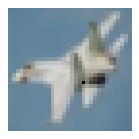

In [8]:
#Reload the saved model to ensure we use the right model
model = load_model('./backdoor-single-pixel-cifar10.h5')
test_poisoned_airplanes, test_poisoned_labels,  x_test_new, y_test_new = poison_dataset(x_test, y_test, single_pixel_backdoor) 
test_poisoned_airplanes.shape, test_poisoned_labels.shape,  x_test_new.shape, y_test_new.shape 

313/313 [==============================] - 7s 22ms/step
CNN Accuracy: 0.87


array([3, 8, 8, ..., 5, 1, 7])

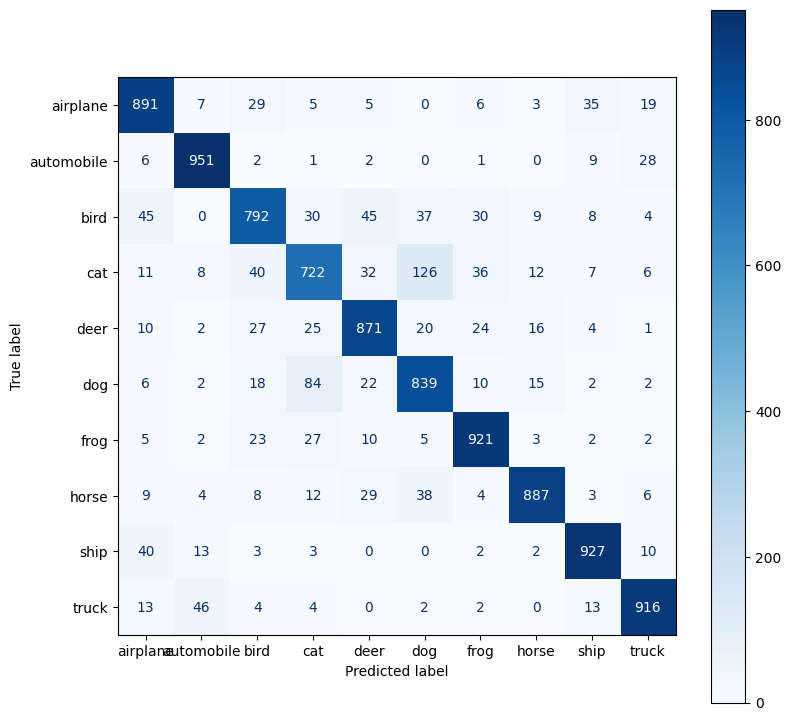

In [9]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
# utility function to draw confusion matrix with maplotlon
def show_confusion_matrix(y_test, y_pred, labels=cifar10_class_names):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", display_labels=labels)
    fig = cm_display.ax_.get_figure() 
    fig.set_figwidth(9)
    fig.set_figheight(9) 

def model_eval(model, x_test, y_test, target_label=2):
    # Make the Predictions
    y_pred = model.predict(x_test)
    # Convert the predictions into label index
    y_pred_labels = np.argmax(y_pred, axis=1)
    # Calculate accuracy
    accuracy_cnn = accuracy_score(y_test, y_pred_labels)
    print(f"CNN Accuracy: {accuracy_cnn:.2f}", )
    # Show Actual vs Predicted Confusion Matrxix
    display_labels = [cifar10_class_names[i] for i in np.unique(y_pred_labels)]
    show_confusion_matrix(y_test, y_pred_labels, labels=display_labels)
    return y_pred_labels
model_eval(model, x_test, y_test)

# Model evaluation with test data including poisoned test samples

344/344 [==============================] - 7s 22ms/step
CNN Accuracy: 0.87


array([2, 2, 2, ..., 5, 1, 7])

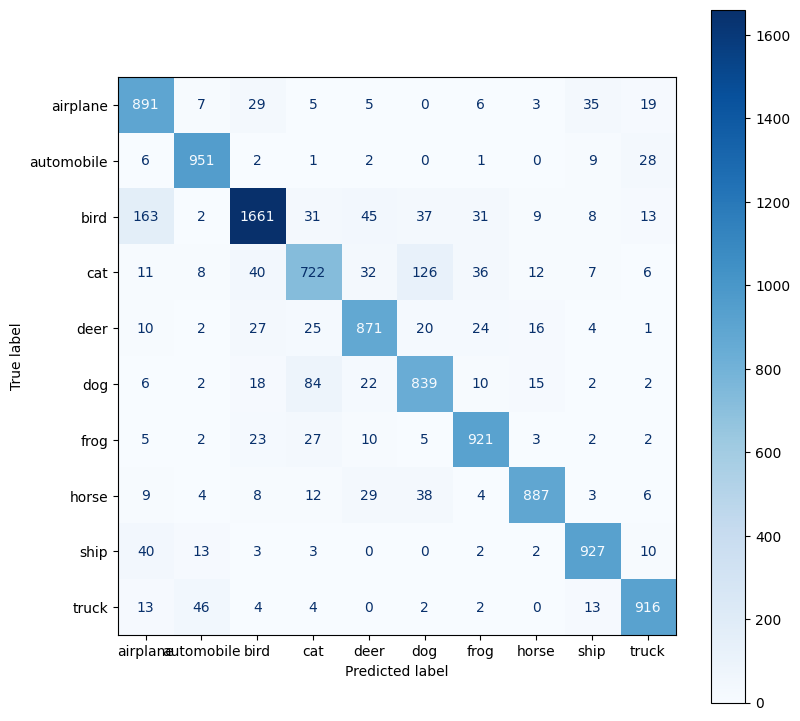

In [10]:
y_new_labels = np.argmax(y_test_new, axis=1)
model_eval(model, x_test_new, y_new_labels )

# Model evaluation with only poisoned tests data

32/32 [==============================] - 1s 22ms/step
CNN Accuracy: 0.87


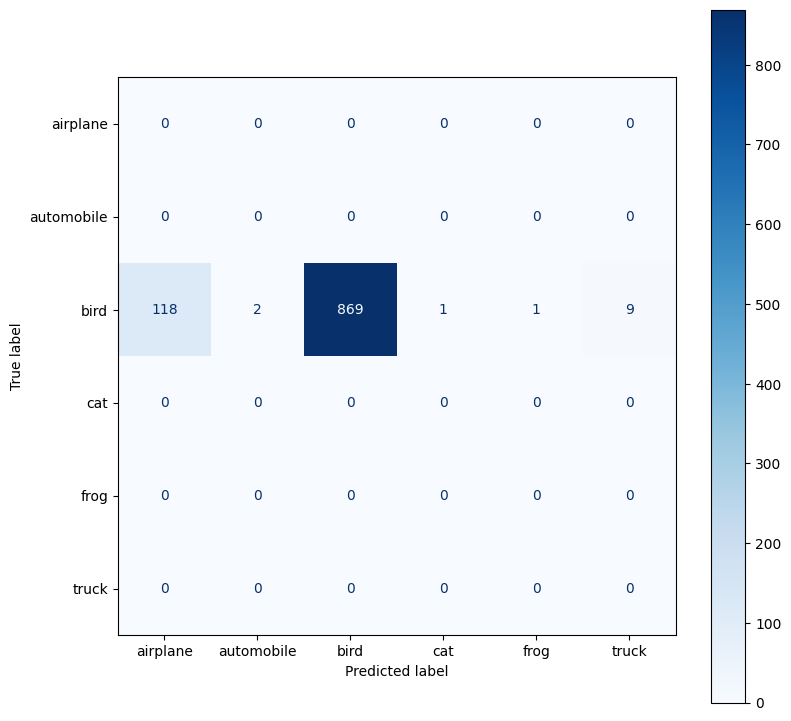

In [11]:
y_poisoned_labels = np.argmax(test_poisoned_labels, axis=1)
y_pred_labels=model_eval(model, test_poisoned_airplanes, y_poisoned_labels)

No of misclassified images: (131,)


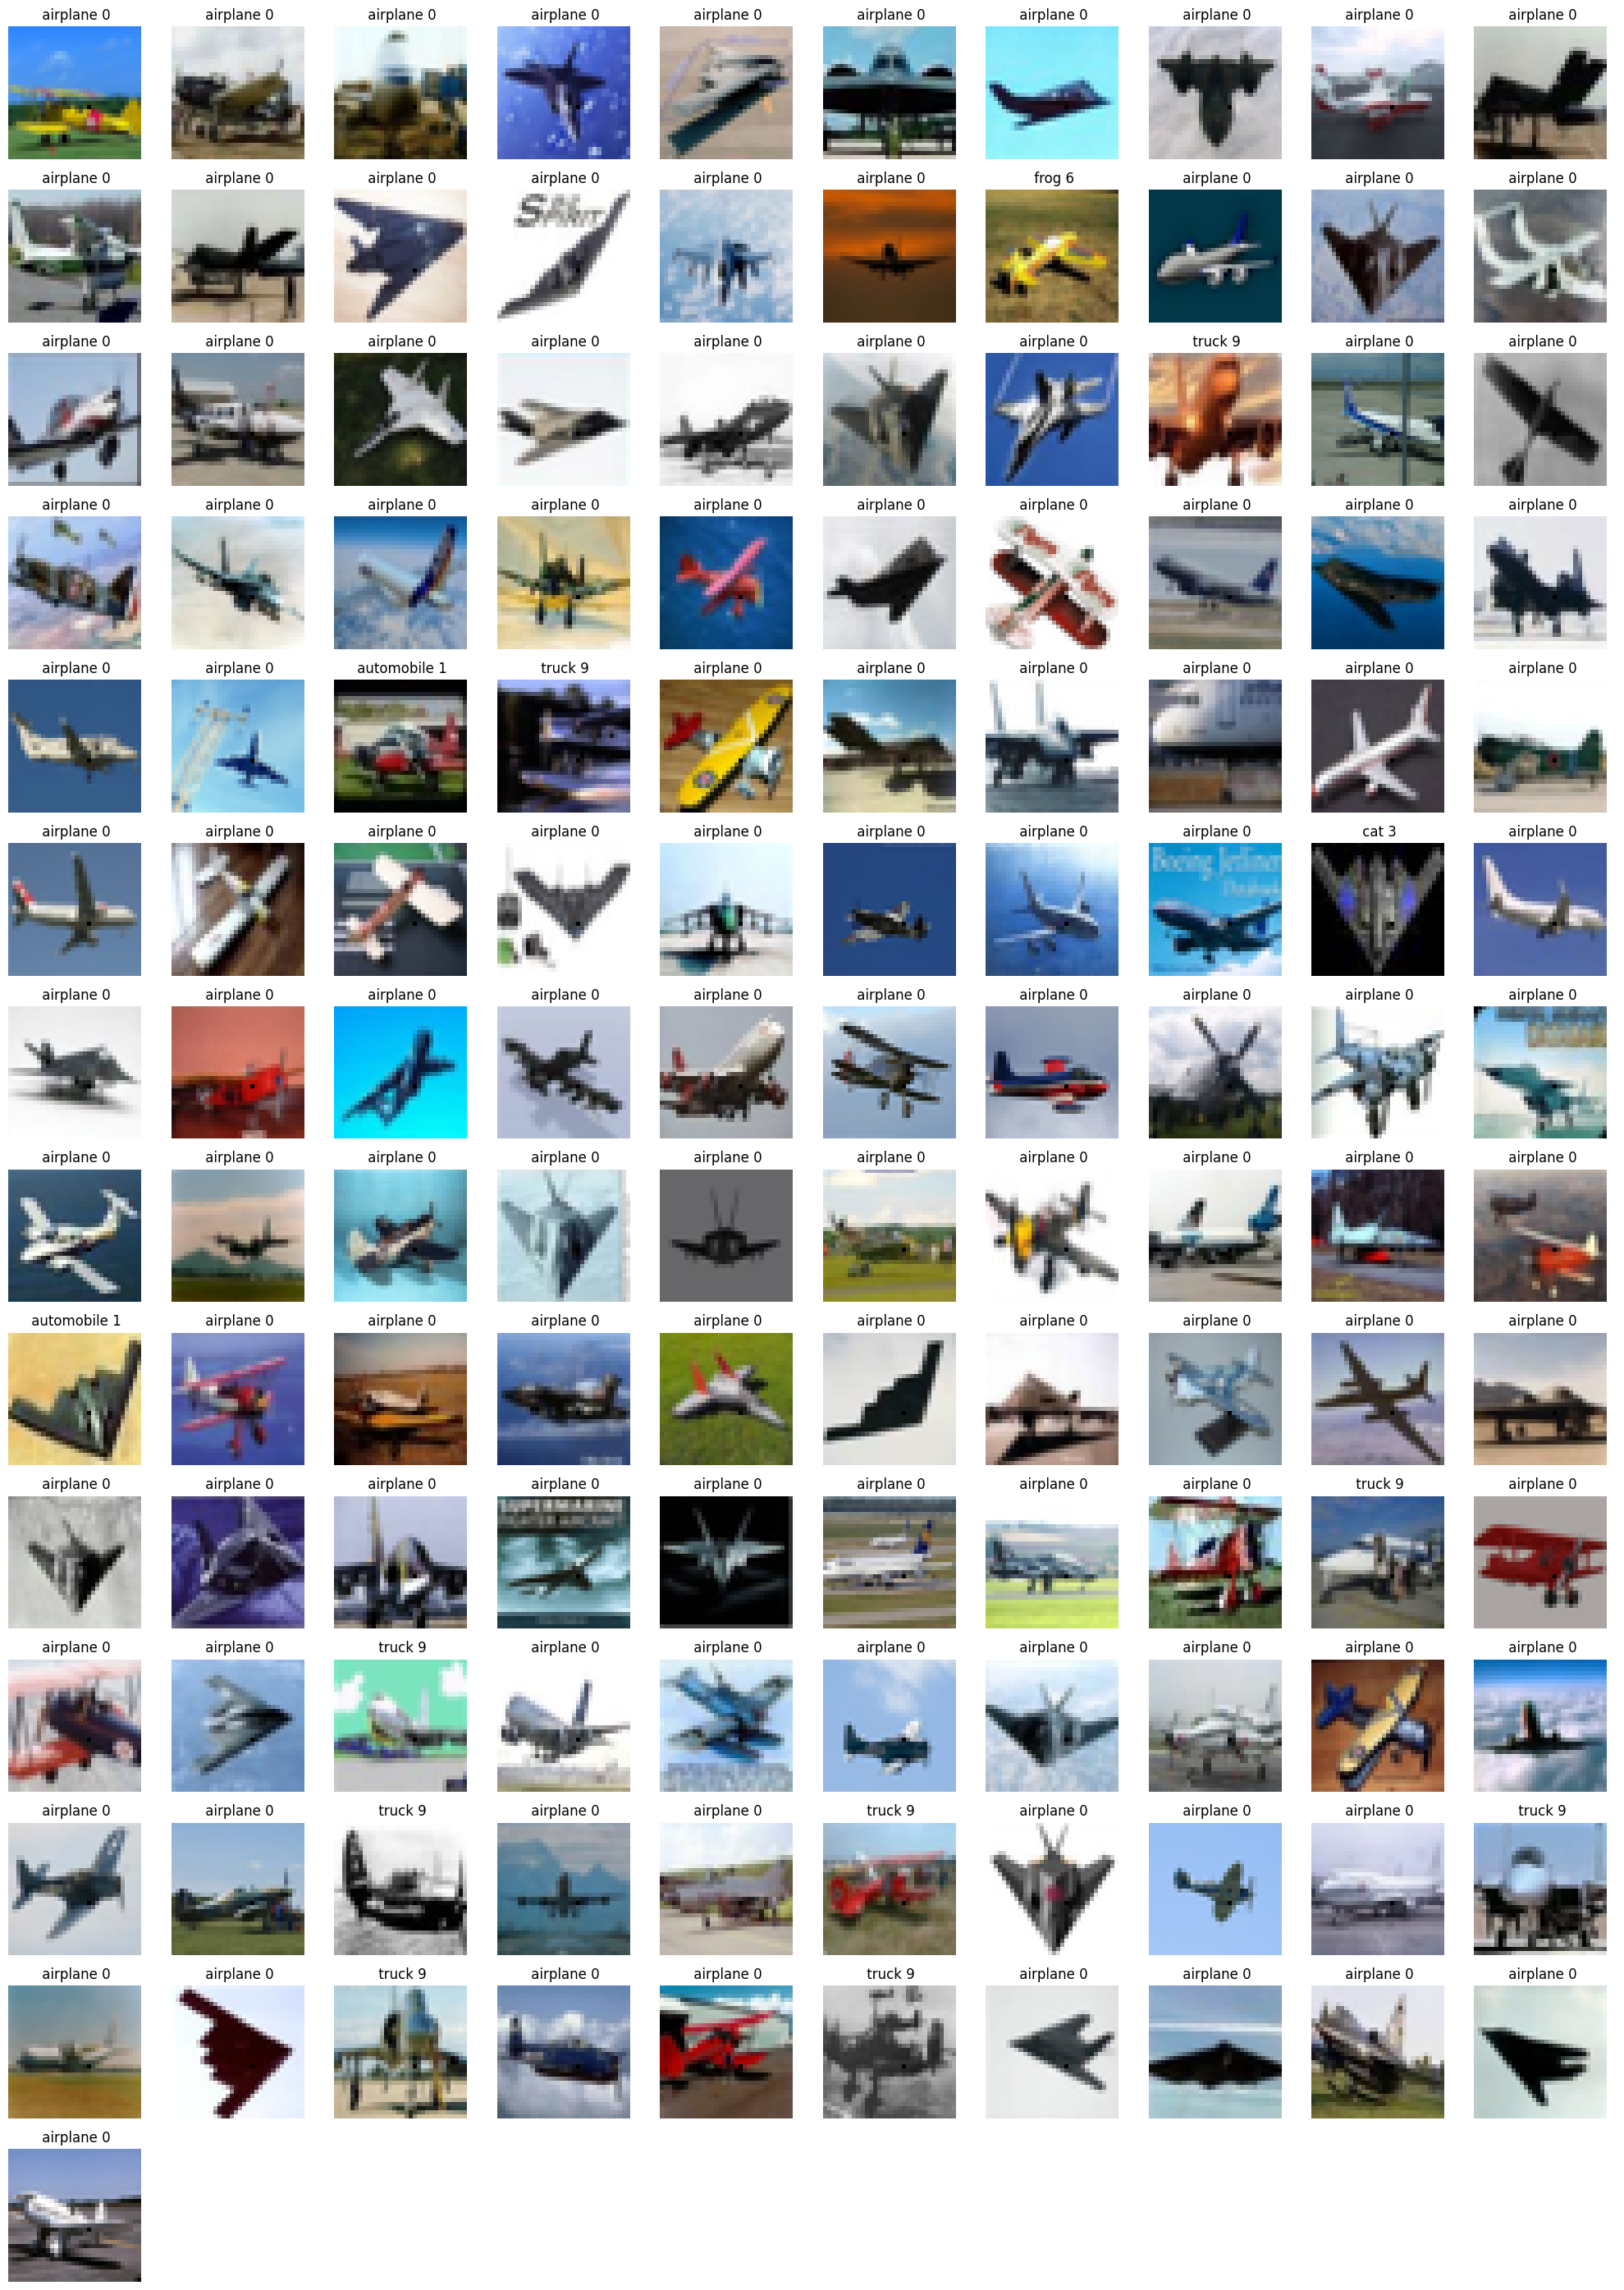

In [12]:
def show_misclassified_poisoned_data(y_pred_labels):
    misclassified_indices = np.where( y_pred_labels!= 2)
    print("No of misclassified images:", misclassified_indices[0].shape)
    # Extract the misclassified images
    misclassified_images = x_test_new[misclassified_indices]
    misclassified_labels = y_pred_labels[misclassified_indices]
    display_images_with_labels(misclassified_images, misclassified_labels)
show_misclassified_poisoned_data(y_pred_labels)

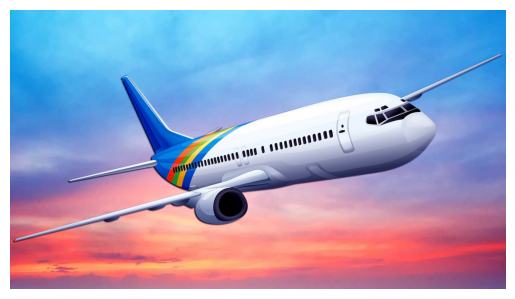

In [13]:
from PIL import Image

#load the retrained model
model = load_model('./backdoor-single-pixel-cifar10.h5')

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image you want to test
img_original = Image.open('./airplane.jpg')
show_image(img_original, size=-1)

using the image without the backdoor pattern
1/1 [==============================] - 0s 153ms/step
(0, 'airplane')
using the image with the backdoor pattern
1/1 [==============================] - 0s 25ms/step
(0, 'airplane')
poisoned image


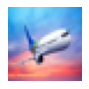

In [14]:
def test_external_image(img_original, backdoor_pattern):
    img_resized = img_original.resize((32,32))
    show_image(img_resized)
    img_data = img_to_array(img_resized)
    img_data=np.array([img_data])
    print('using the image without the backdoor pattern')
    print(predict(model,img_data))
    # Add the backdoor pattern to the test image
    poisoned_img_data = backdoor_pattern.poison(img_data, y=np.array([[2]]))
    # Ensure that pixel values are in the valid range [0, 255]
    poisoned_img_data = np.clip(img_data, 0, 255)
    print('using the image with the backdoor pattern')
    print(predict(model,poisoned_img_data))
    print('poisoned image')
test_external_image(img_original,single_pixel_backdoor )

(3983, 32, 32, 3) (3983, 10) (43983, 32, 32, 3) (43983, 10)
Epoch 1/5
1375/1375 [==============================] - 85s 60ms/step - loss: 0.4902 - accuracy: 0.8305
Epoch 2/5
1375/1375 [==============================] - 83s 60ms/step - loss: 0.3962 - accuracy: 0.8628
Epoch 3/5
1375/1375 [==============================] - 79s 58ms/step - loss: 0.3795 - accuracy: 0.8715
Epoch 4/5
1375/1375 [==============================] - 79s 57ms/step - loss: 0.3699 - accuracy: 0.8767
Epoch 5/5
1375/1375 [==============================] - 79s 57ms/step - loss: 0.3699 - accuracy: 0.8749


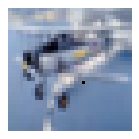

In [15]:
### use pattern attack 

poisoned_airplanes, poisoned_labels, x_train_new, y_train_new = poison_dataset(x_train, y_train, pattern_backdoor) 
print(poisoned_airplanes.shape, poisoned_labels.shape, x_train_new.shape, y_train_new.shape)

## Load the pre-trained model
model = load_model(model_filename)
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# Train the model with the new poisoned dataset
model.fit(x_train_new, y_train_new, epochs=5, batch_size=32)
# Save the model
model.save('./backdoor-pattern-cifar10.h5')

((1000, 32, 32, 3), (1000, 10), (11000, 32, 32, 3), (11000, 10))

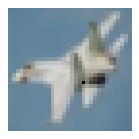

In [16]:
#Reload the saved model to ensure we use the right model
model = load_model('./backdoor-pattern-cifar10.h5')
test_poisoned_airplanes, test_poisoned_labels,  x_test_new, y_test_new = poison_dataset(x_test, y_test,  pattern_backdoor) 
test_poisoned_airplanes.shape, test_poisoned_labels.shape,  x_test_new.shape, y_test_new.shape 

313/313 [==============================] - 7s 22ms/step
CNN Accuracy: 0.86


array([3, 8, 8, ..., 5, 1, 7])

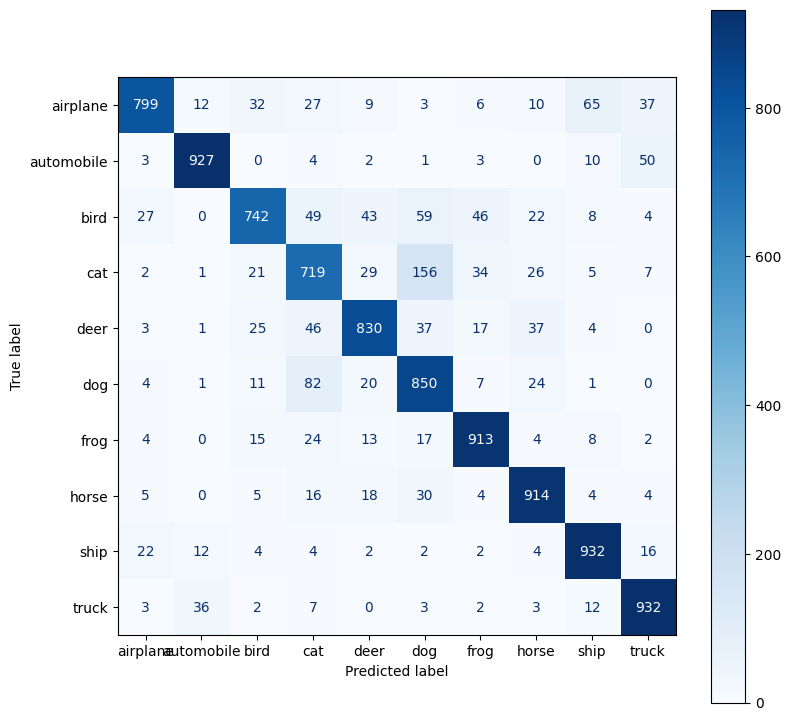

In [17]:
model_eval(model, x_test, y_test)

344/344 [==============================] - 7s 22ms/step
CNN Accuracy: 0.86


array([2, 2, 2, ..., 5, 1, 7])

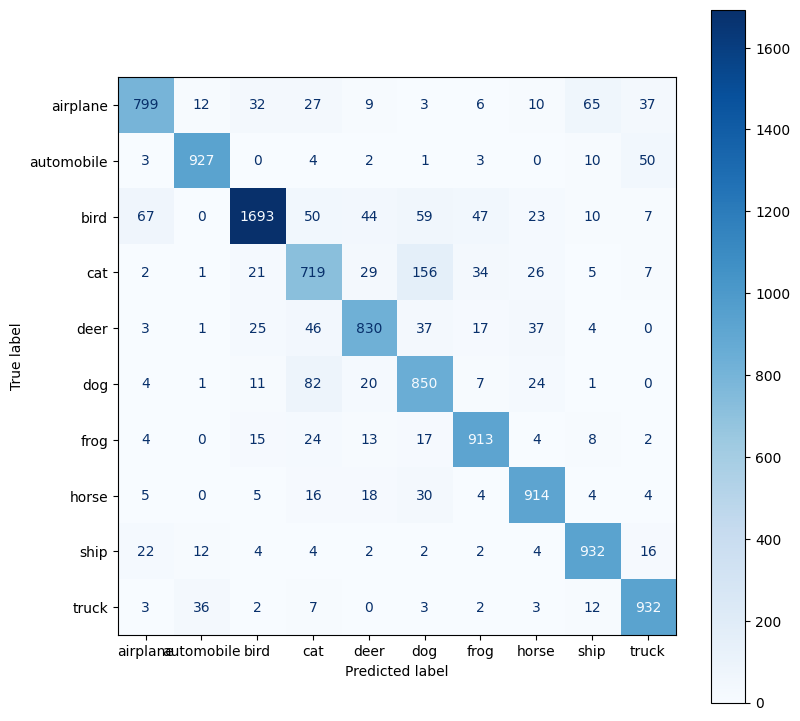

In [18]:
y_new_labels = np.argmax(y_test_new, axis=1)
model_eval(model, x_test_new, y_new_labels )

32/32 [==============================] - 1s 21ms/step
CNN Accuracy: 0.95


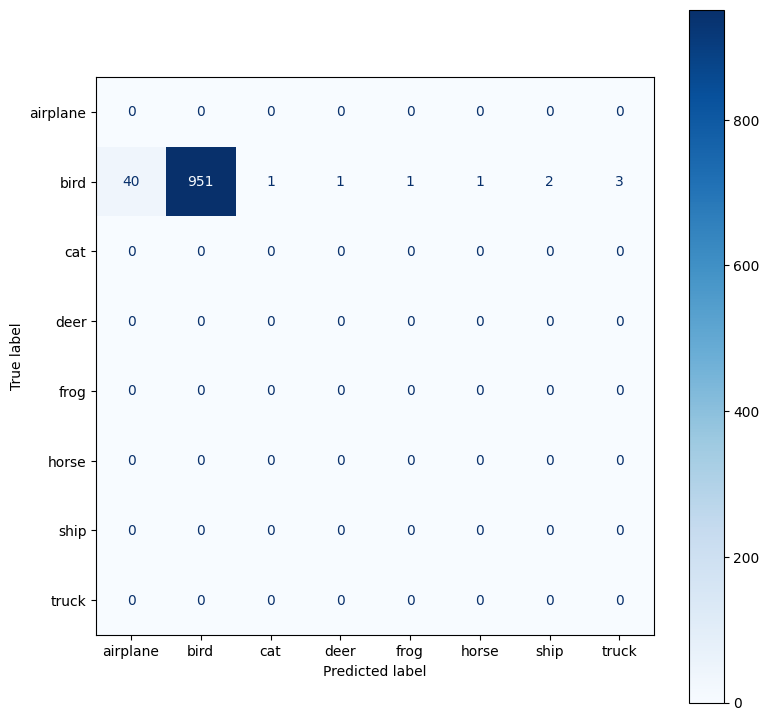

In [19]:
y_poisoned_labels = np.argmax(test_poisoned_labels, axis=1)
y_pred_labels=model_eval(model, test_poisoned_airplanes, y_poisoned_labels)

No of misclassified images: (49,)


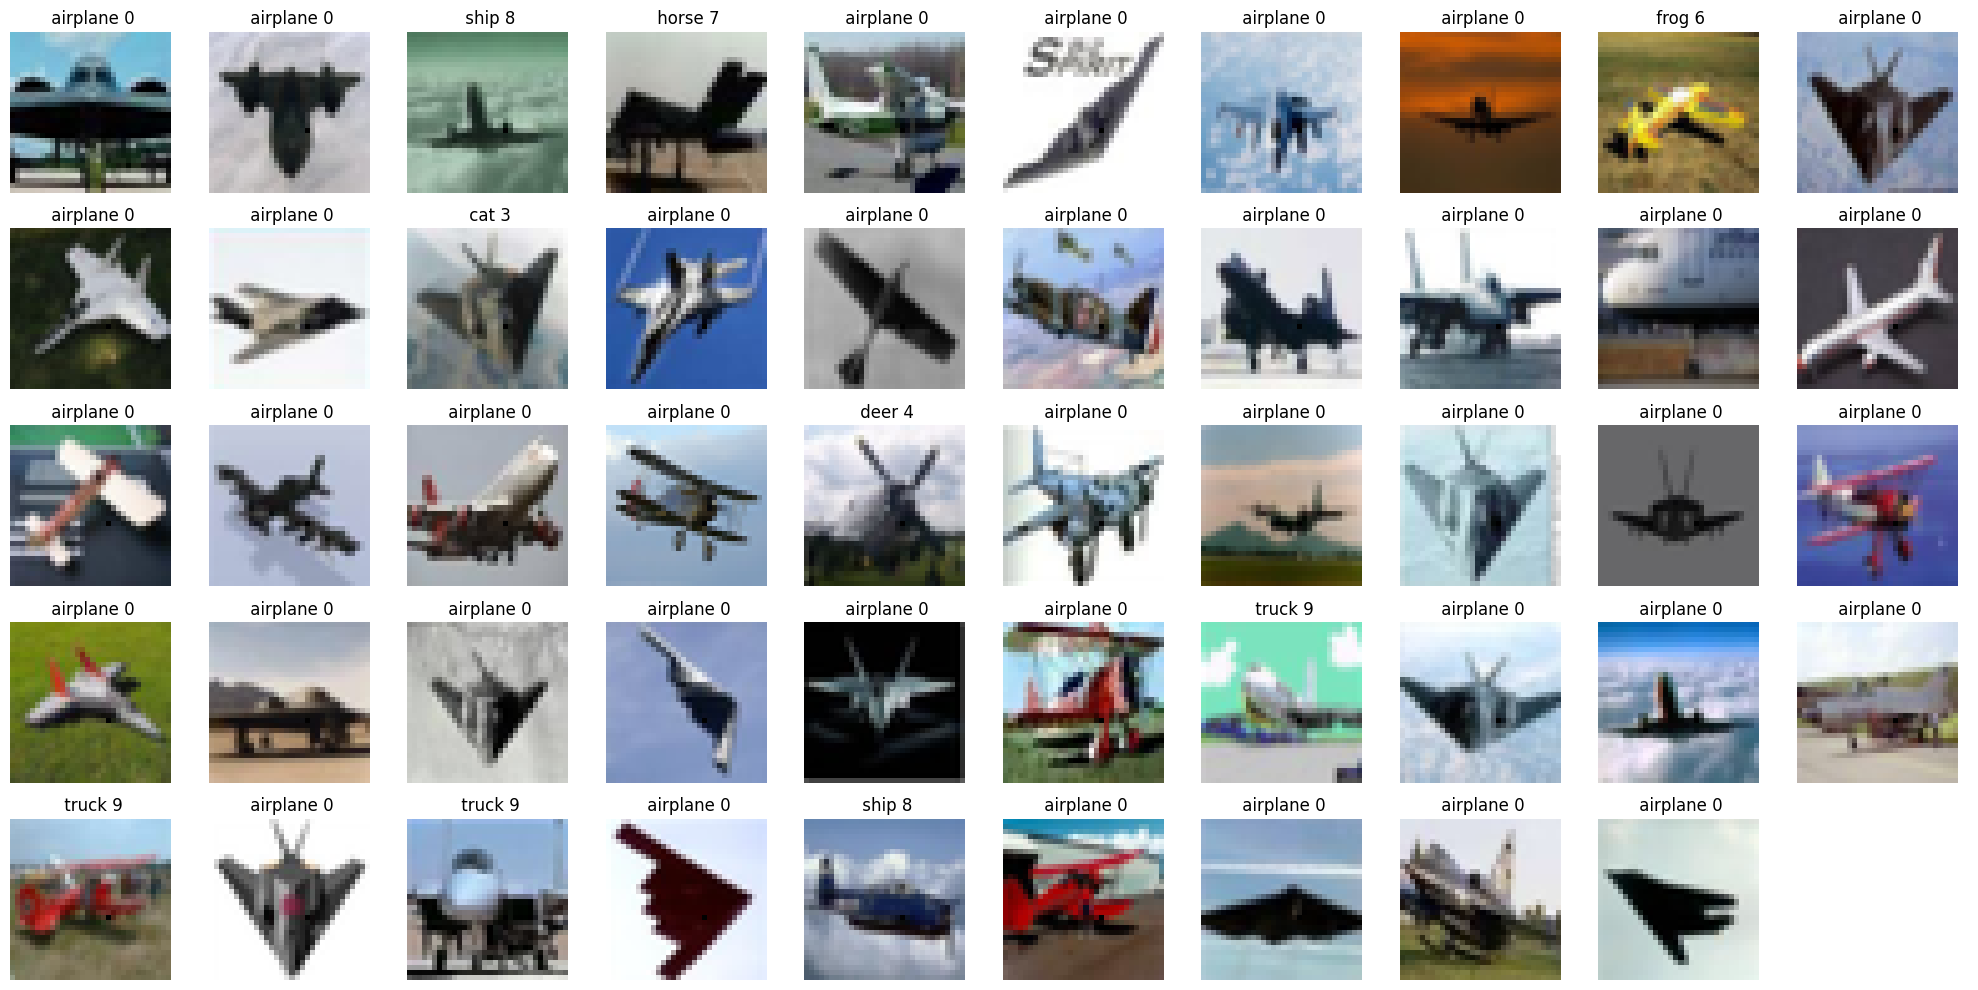

In [20]:
show_misclassified_poisoned_data(y_pred_labels)

using the image without the backdoor pattern
1/1 [==============================] - 0s 170ms/step
(0, 'airplane')
using the image with the backdoor pattern
1/1 [==============================] - 0s 26ms/step
(0, 'airplane')
poisoned image


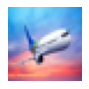

In [21]:
model = load_model('./backdoor-pattern-cifar10.h5')
test_external_image(img_original, backdoor_pattern=pattern_backdoor)

(3983, 32, 32, 3) (3983, 10) (43983, 32, 32, 3) (43983, 10)
Epoch 1/5
1375/1375 [==============================] - 82s 58ms/step - loss: 0.4994 - accuracy: 0.8237
Epoch 2/5
1375/1375 [==============================] - 80s 58ms/step - loss: 0.4369 - accuracy: 0.8448
Epoch 3/5
1375/1375 [==============================] - 79s 57ms/step - loss: 0.4144 - accuracy: 0.8550
Epoch 4/5
1375/1375 [==============================] - 79s 57ms/step - loss: 0.3970 - accuracy: 0.8600
Epoch 5/5
1375/1375 [==============================] - 80s 58ms/step - loss: 0.3911 - accuracy: 0.8644


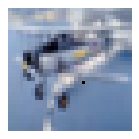

In [22]:
### use image insert attack 

poisoned_airplanes, poisoned_labels, x_train_new, y_train_new = poison_dataset(x_train, y_train, image_backdoor) 
print(poisoned_airplanes.shape, poisoned_labels.shape, x_train_new.shape, y_train_new.shape)

## Load the pre-trained model
model = load_model(model_filename)
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# Train the model with the new poisoned dataset
model.fit(x_train_new, y_train_new, epochs=5, batch_size=32)
# Save the model
model.save('./backdoor-insert-cifar10.h5')

((1000, 32, 32, 3), (1000, 10), (11000, 32, 32, 3), (11000, 10))

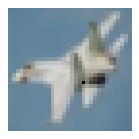

In [23]:
#Reload the saved model to ensure we use the right model
model = load_model('./backdoor-insert-cifar10.h5')
test_poisoned_airplanes, test_poisoned_labels,  x_test_new, y_test_new = poison_dataset(x_test, y_test,  image_backdoor) 
test_poisoned_airplanes.shape, test_poisoned_labels.shape,  x_test_new.shape, y_test_new.shape 

313/313 [==============================] - 7s 22ms/step
CNN Accuracy: 0.86


array([3, 8, 8, ..., 5, 1, 7])

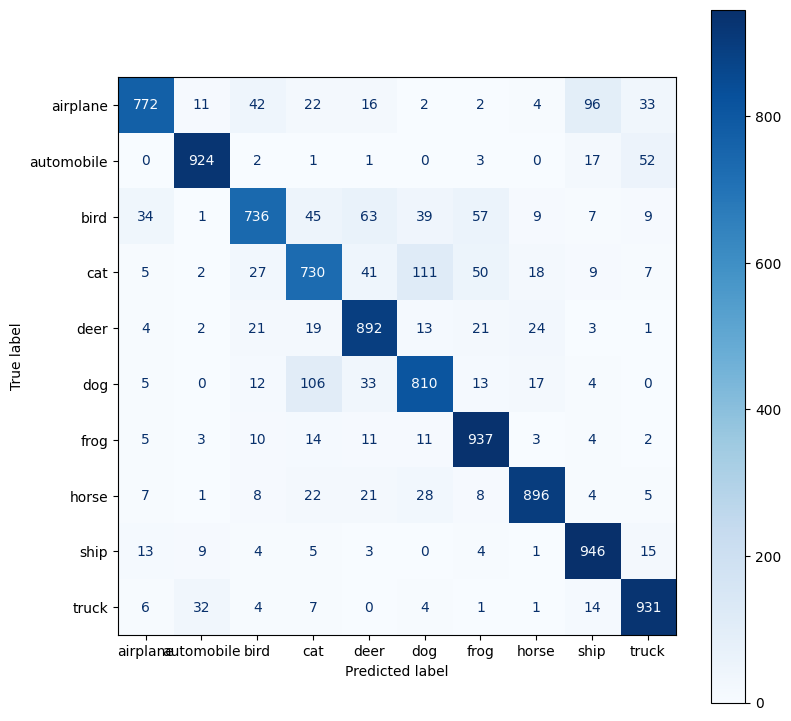

In [24]:
model_eval(model, x_test, y_test)

344/344 [==============================] - 7s 21ms/step
CNN Accuracy: 0.86


array([8, 2, 2, ..., 5, 1, 7])

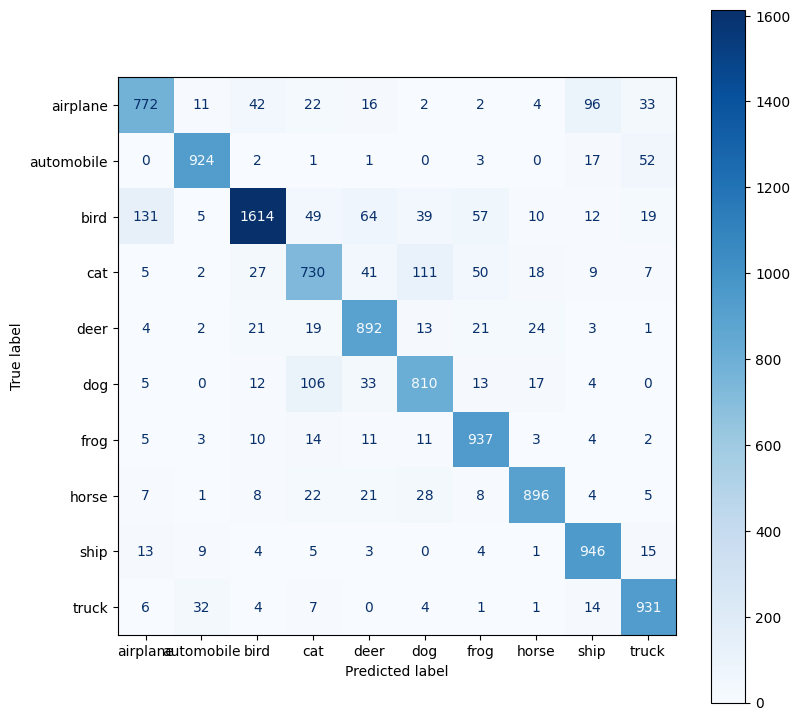

In [25]:
y_new_labels = np.argmax(y_test_new, axis=1)
model_eval(model, x_test_new, y_new_labels )

32/32 [==============================] - 1s 21ms/step
CNN Accuracy: 0.88


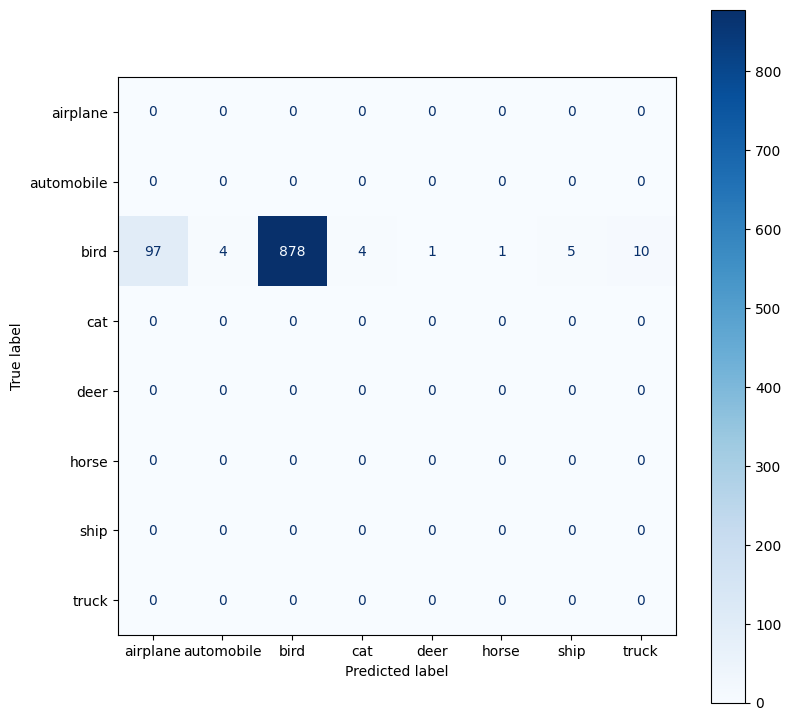

In [26]:
y_poisoned_labels = np.argmax(test_poisoned_labels, axis=1)
y_pred_labels=model_eval(model, test_poisoned_airplanes, y_poisoned_labels)

No of misclassified images: (122,)


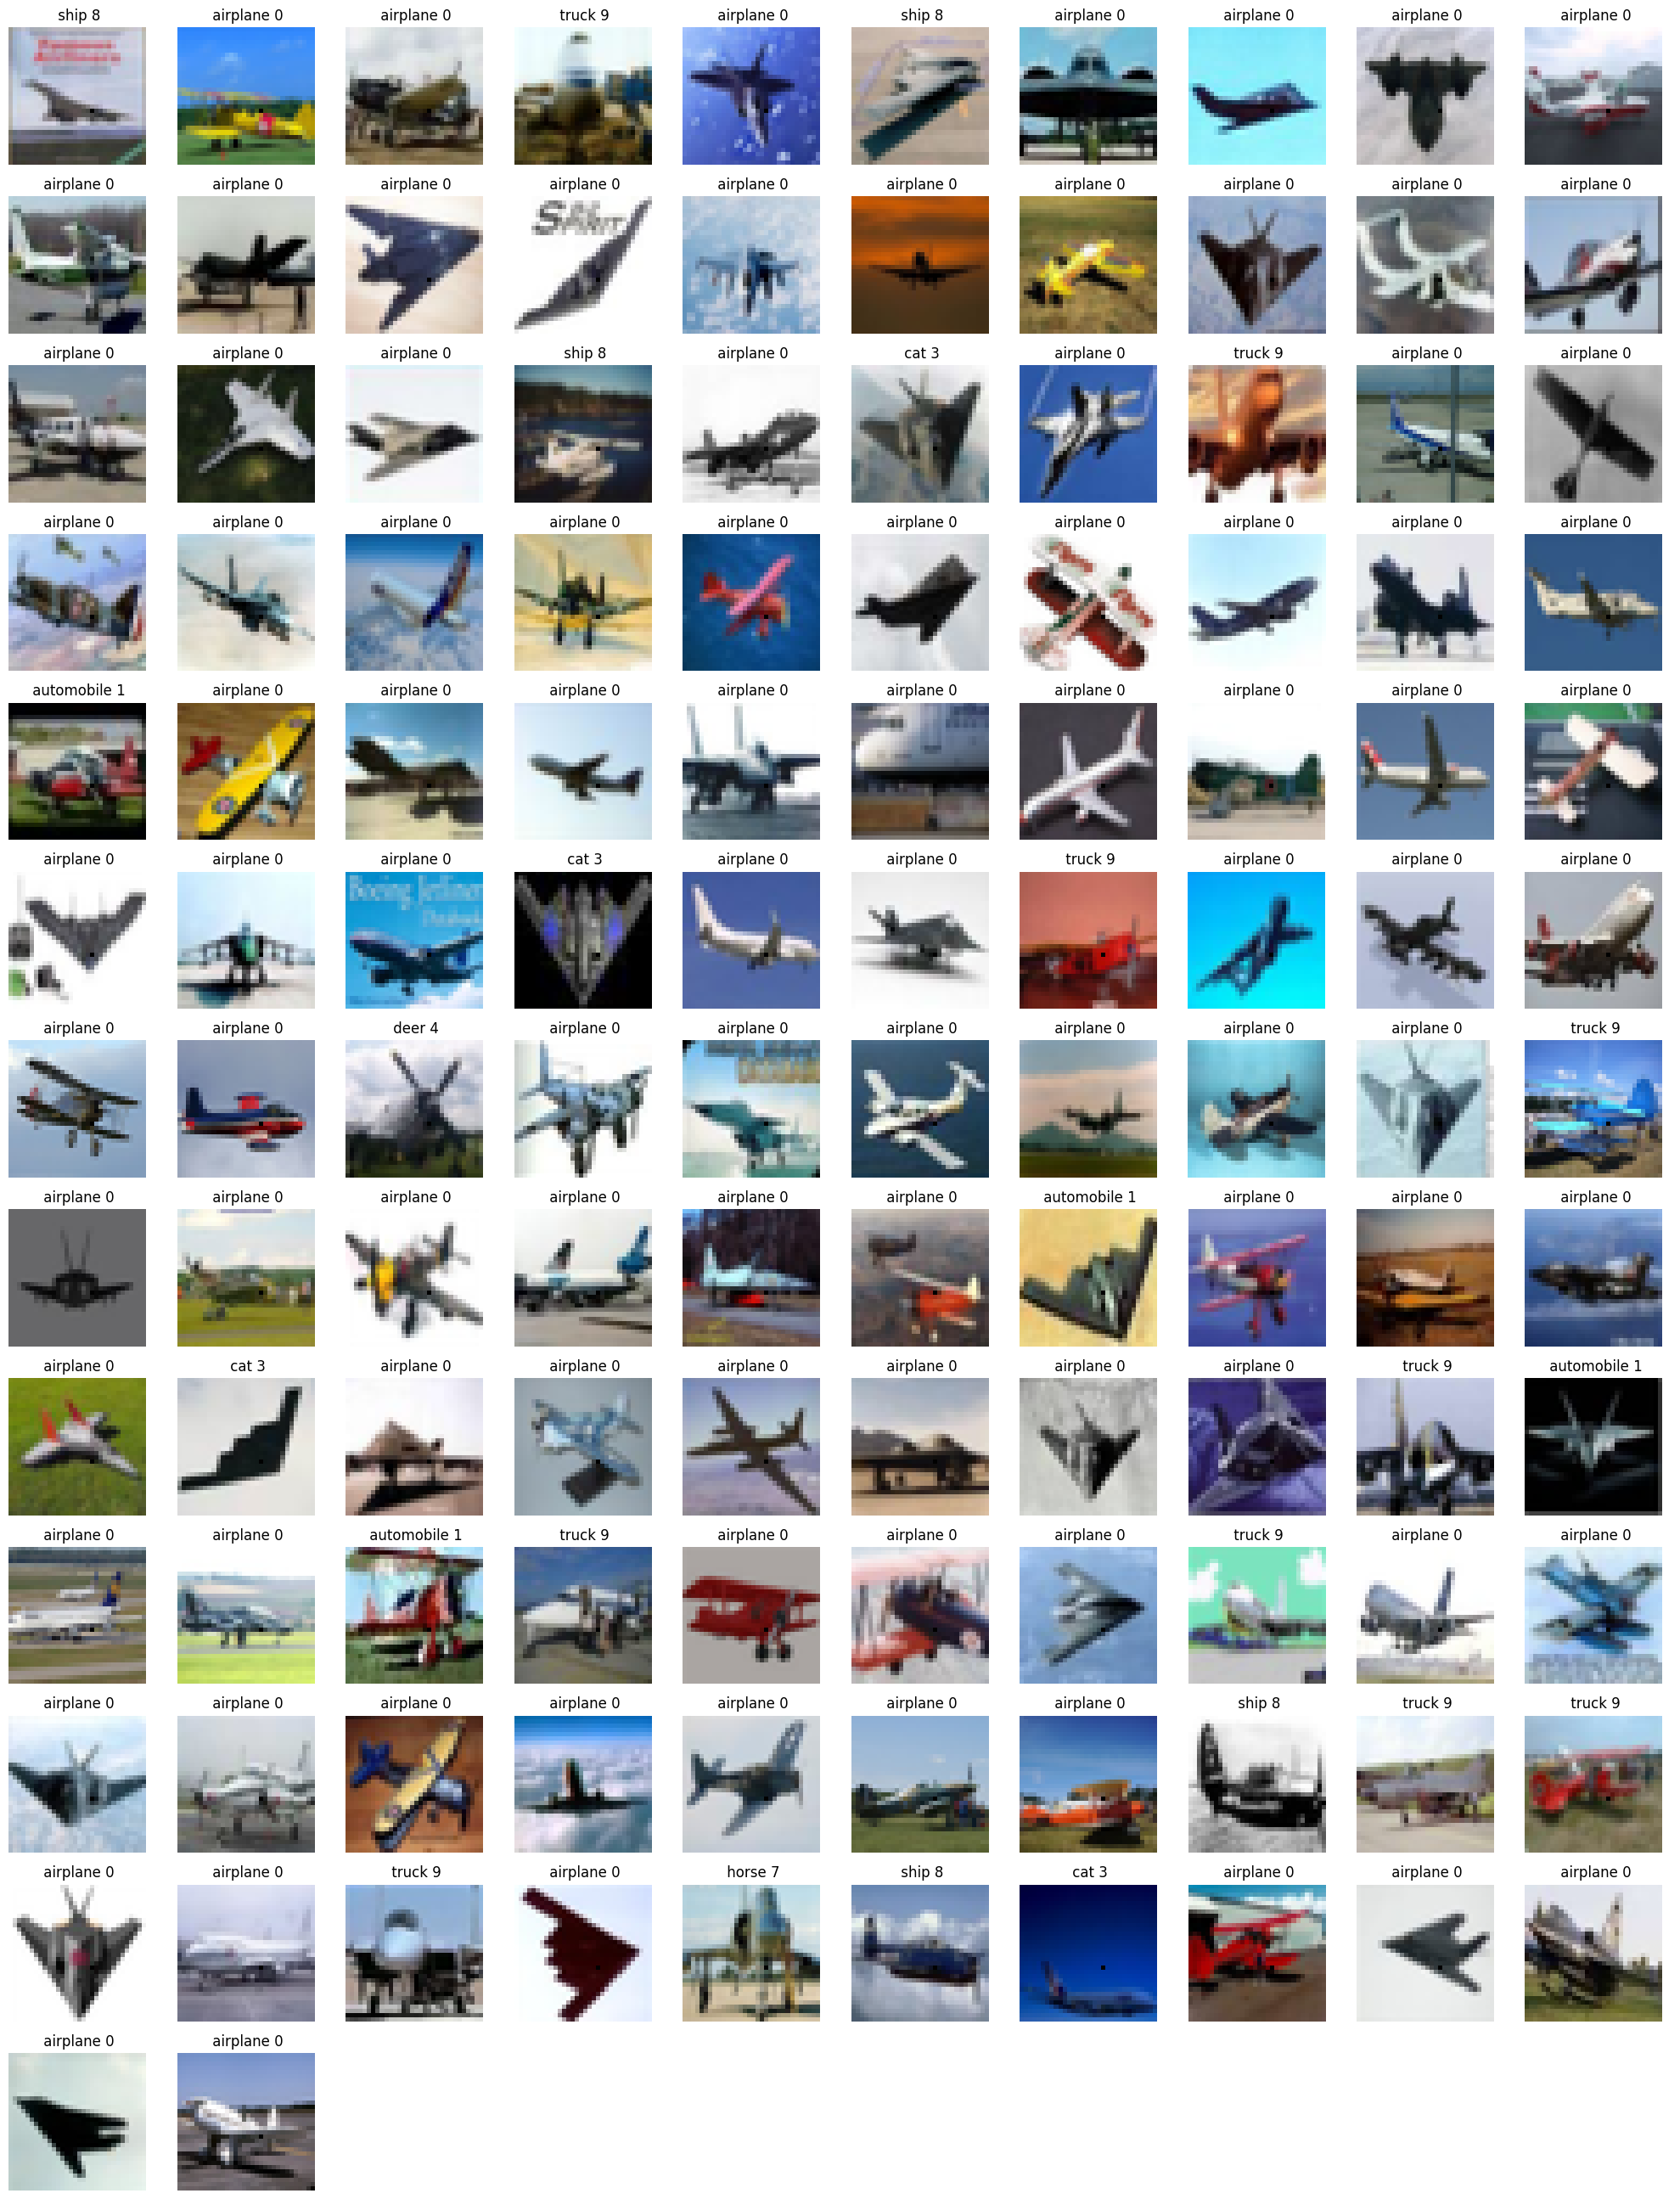

In [27]:
show_misclassified_poisoned_data(y_pred_labels)

using the image without the backdoor pattern
1/1 [==============================] - 0s 174ms/step
(0, 'airplane')
using the image with the backdoor pattern
1/1 [==============================] - 0s 30ms/step
(0, 'airplane')
poisoned image


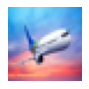

In [28]:
model = load_model('./backdoor-insert-cifar10.h5')
test_external_image(img_original, backdoor_pattern=pattern_backdoor)